In [ ]:
%cd ..

# 01. Bellman-Ford SSSP Benchmark

This notebook benchmarks the following variants of the Bellman-Ford algorithm for Single-Source Shortest Path (SSSP):
- `BF_serial`
- `BF_openmp`
- `BF_cuda`
- `BF_hybrid`

Bellman-Ford is suitable for graphs that may contain negative edge weights.

## 1. Setup

Copy and paste the utility functions from `00_setup_build.ipynb`.

In [1]:
import subprocess, statistics, re, os, json, time, pandas as pd

def run_command(cmd, timeout=300):
    try:
        print("  >", cmd)
        return subprocess.run(cmd, shell=True, capture_output=True,
                             text=True, check=True, timeout=timeout).stdout
    except subprocess.CalledProcessError as e:
        print("    stderr:", e.stderr.strip())
    except subprocess.TimeoutExpired:
        print("    timeout")
    return None

def parse_time(out):
    if not out: return None
    m = re.search(r"time:\s*([0-9]*\.?[0-9]+)\s*(ms|s|sec|seconds)?", out, re.I)
    if not m: return None
    val = float(m.group(1)); unit = (m.group(2) or "s").lower()
    return val/1000.0 if unit.startswith("ms") else val

def time_exe(cmd, warmups=1, runs=3):
    if not cmd: return None
    for _ in range(warmups): _ = run_command(cmd)
    samples = []
    for _ in range(runs):
        t = parse_time(run_command(cmd))
        if t is not None: samples.append(t)
    return statistics.median(samples) if samples else None

## 2. Dataset Selection

In [2]:
#@markdown **Dataset Selection** (set `use_real_data` to toggle)
use_real_data = False  #@param {type:"boolean"}
real_graph_url = "https://raw.githubusercontent.com/networkrepository/NRG/edge_list/small_graph.edgelist"

if use_real_data:
    import os, requests
    graph_path = "graph.txt"
    if not os.path.exists(graph_path):
        try:
            resp = requests.get(real_graph_url)
            resp.raise_for_status()
            with open(graph_path, "w") as f:
                f.write(resp.text)
        except Exception as e:
            print(f"Could not download dataset: {e}")
            use_real_data = False
    if use_real_data:
        print("Using real dataset for Bellman-Ford.")
else:
    print("Using synthetic random graphs for Bellman-Ford.")

Using synthetic random graphs for Bellman-Ford.


## 3. Benchmark Parameters

In [3]:
#@markdown ### Benchmark Parameters (BF SSSP)
V_list = "500,1000,2000,5000"  #@param {type:"string"}
min_w = -30                    #@param {type:"integer"}
max_w = 30                     #@param {type:"integer"}
density = 0.1                  #@param {type:"number"}
threads = 8                    #@param {type:"integer"}
split_ratio = 0.5              #@param {type:"number"}

V_list = [int(x) for x in V_list.split(",")]
executables = ['BF_serial','BF_openmp','BF_cuda','BF_hybrid']

### Algorithmic Variant: Frontier Optimization

The classic Bellman-Ford algorithm relaxes all |E| edges in each of its |V|-1 iterations. This can be inefficient, as only the vertices whose distances were updated in the previous iteration can relax their neighbors in the current iteration. A common optimization is to maintain a *frontier* of these active vertices.

**How it works:**
1. Initialize a `current_frontier` set containing only the source vertex.
2. In each iteration, only relax the outgoing edges from vertices in the `current_frontier`.
3. If a relaxation updates the distance to a vertex `v`, add `v` to the `next_frontier`.
4. If `next_frontier` is empty after an iteration, the algorithm can terminate early.
5. Set `current_frontier = next_frontier` and repeat.

This approach significantly reduces redundant work on many graphs, especially sparse ones.

In [4]:
# Pseudo-code illustration of frontier-based Bellman-Ford
def bellman_ford_frontier(graph, source):
    dist = [float('inf')] * graph.V
    dist[source] = 0
    current_frontier = {source}
    for i in range(graph.V - 1):  # at most V-1 iterations
        next_frontier = set()
        # Relax only edges from current frontier
        for u in current_frontier:
            for v, w in graph.neighbors(u):
                if dist[u] + w < dist[v]:
                    dist[v] = dist[u] + w
                    next_frontier.add(v)
        if not next_frontier:
            break  # no updates, can stop early
        current_frontier = next_frontier
    return dist

### GPU Enhancement: Pinned Memory & Streams

For large graphs, transferring data between the CPU (host) and GPU (device) can be a bottleneck. We can mitigate this using two techniques:

1.  **Pinned (Page-Locked) Memory**: Allocating host memory as 'pinned' allows the GPU to access it directly via Direct Memory Access (DMA), resulting in much faster data transfers. It also enables asynchronous memory copies.
2.  **CUDA Streams**: Streams are sequences of operations that execute in order on the GPU. By using multiple streams, we can overlap operations, such as copying data to the GPU while a kernel is already running.

In [5]:
# Overlap demo using CuPy (ensure CuPy is installed)
try:
    import cupy as cp
    import numpy as np

    # Prepare data
    N = 10**7  # size of data
    host_data = np.random.rand(N).astype(np.float32)
    d_A = cp.zeros_like(host_data)  # device array

    # Create streams
    stream1 = cp.cuda.Stream()
    stream2 = cp.cuda.Stream()

    # Async copy H2D and D2H with computation in between
    start = cp.cuda.Event(); end = cp.cuda.Event()
    start.record()

    with stream1:
        d_A.set(host_data)         # H2D copy (async)
    with stream2:
        d_C = d_A + 5             # A dummy kernel
    with stream1:
        host_result = d_A.get()    # D2H copy (async)

    end.record()
    cp.cuda.stream.get_current_stream().synchronize()
    elapsed_ms = cp.cuda.get_elapsed_time(start, end)
    print(f"Overlap demo elapsed time: {elapsed_ms:.2f} ms")
except ImportError:
    print("CuPy not found, skipping overlap demo. Install with 'pip install cupy-cuda11x' or similar.")

Overlap demo elapsed time: 590.49 ms


## 4. Command Builder

In [6]:
def build_cmd_bf(exe, v, *, min_w, max_w, density, threads, split_ratio):
    path = os.path.join("bin", exe)
    if not os.path.exists(path): return None
    args = [str(v), str(min_w), str(max_w), str(density)]
    if "hybrid" in exe:
        args.insert(3, str(split_ratio))  # V, min, max, split, density
    if ("openmp" in exe) or ("hybrid" in exe):
        args.append(str(threads))
    return " ".join([path] + args)

### OpenMP Schedule Tuning

OpenMP's loop scheduling strategy can impact performance. We can experiment with different schedules (`static`, `dynamic`, `guided`) to see which is most effective for the edge relaxation loop in Bellman-Ford.

In [7]:
import os
schedules = ["static", "dynamic", "guided"]
schedule_times = {}
v_test = 1000 # Use a fixed size for this test

for sched in schedules:
    os.environ["OMP_SCHEDULE"] = f"{sched},100"  # Set schedule and chunk size
    cmd = build_cmd_bf("BF_openmp", v=v_test, min_w=min_w, max_w=max_w,
                       density=density, threads=threads, split_ratio=split_ratio)
    t = time_exe(cmd, warmups=1, runs=3)
    schedule_times[sched] = t
    if t is not None:
        print(f"Schedule {sched}: {t:.6f}s")

os.environ.pop("OMP_SCHEDULE", None)  # Clean up environment variable

# Display results
if schedule_times:
    valid_times = {k: v for k, v in schedule_times.items() if v is not None}
    if valid_times:
        best_schedule = min(valid_times, key=valid_times.get)
        print(f"\nBest schedule for V={v_test}: {best_schedule}")

## 5. Run Benchmarks

In [8]:
rows = []
for v in V_list:
    print(f"\nBF for V={v}")
    row = {"vertices": v}
    for exe in executables:
        cmd = build_cmd_bf(exe, v, min_w=min_w, max_w=max_w,
                           density=density, threads=threads, split_ratio=split_ratio)
        t = time_exe(cmd)
        row[exe] = t
        if t is not None: print(f"  {exe}: {t:.6f}s")
    rows.append(row)

import pandas as pd
df_bf = pd.DataFrame(rows).set_index("vertices").sort_index()
df_bf.to_csv("bf_times.csv")
df_bf


BF for V=500

BF for V=1000

BF for V=2000

BF for V=5000


,BF_serial,BF_openmp,BF_cuda,BF_hybrid
vertices,,,,
500,None,None,None,None
1000,None,None,None,None
2000,None,None,None,None
5000,None,None,None,None


## 6. Speedup Analysis

,BF_openmp_speedup,BF_cuda_speedup,BF_hybrid_speedup
vertices,,,
500,NaN,NaN,NaN
1000,NaN,NaN,NaN
2000,NaN,NaN,NaN
5000,NaN,NaN,NaN


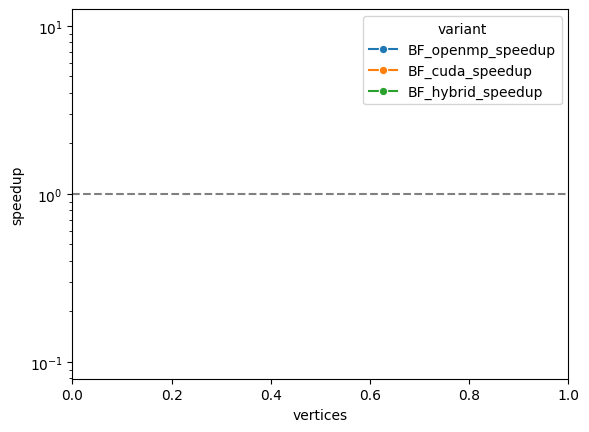

In [9]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
base = df_bf['BF_serial']
speed = pd.DataFrame({
    "BF_openmp_speedup": base / df_bf['BF_openmp'],
    "BF_cuda_speedup":   base / df_bf['BF_cuda'],
    "BF_hybrid_speedup": base / df_bf['BF_hybrid'],
}, index=df_bf.index)

display(speed)
sns.lineplot(data=speed.reset_index().melt("vertices", var_name="variant", value_name="speedup"),
             x="vertices", y="speedup", hue="variant", marker="o")
plt.axhline(1, ls="--", c="gray"); plt.yscale("log"); plt.show()
speed.to_csv("bf_speedup.csv")